# xG Football (StatsBomb Open Data)

This notebook accompanies the capstone project and shows:

- Preparation and cleaning of StatsBomb shot data;
- Exploratory data analysis (EDA) and descriptive statistics;
- Model comparison (Logistic Regression vs RandomForest);
- Feature importance analysis and simple hyperparameter tuning.


## 1. Imports and setup

Make sure you have installed the project dependencies (see `README.md`).


In [1]:
from pathlib import Path

import pandas as pd

from xg_futebol.data_prep import FEATURE_COLUMNS, load_shots_dataframe


## 2. StatsBomb data

Clone StatsBomb open data (outside this notebook):

```bash
cd cohorts/2025/capstone
git clone https://github.com/statsbomb/open-data.git data/statsbomb-open-data
```

The events will be in `data/statsbomb-open-data/data/events`.


In [2]:
events_dir = Path("data/statsbomb-open-data/data/events")
events_dir


PosixPath('data/statsbomb-open-data/data/events')

### 2.1 Load shots

We will load only a subset of matches (`limit_files`) for quick exploration.


In [3]:
df = load_shots_dataframe(events_dir, limit_files=50)
df.shape


(1390, 10)

In [4]:
df.head()


,distance,angle,minute,second,under_pressure,first_time,play_pattern,body_part,shot_type,is_goal
0,15.448625,0.296402,2,29,0,1,From Throw In,Right Foot,Open Play,0
1,14.905368,0.232420,5,39,0,1,Regular Play,Left Foot,Open Play,0
2,26.828716,0.290500,15,29,0,0,From Keeper,Left Foot,Open Play,0
3,10.837435,0.705452,16,20,1,0,Regular Play,Head,Open Play,0
4,19.568597,0.259971,18,16,0,0,From Corner,Right Foot,Open Play,0


### 2.2 Basic data cleaning

The `load_shots_dataframe` function already removes shots without distance/angle/minute. Here we can inspect missing values and types.


In [5]:
df.isna().mean()


distance          0.0
angle             0.0
minute            0.0
second            0.0
under_pressure    0.0
first_time        0.0
play_pattern      0.0
body_part         0.0
shot_type         0.0
is_goal           0.0
dtype: float64

In [6]:
df.describe()


,distance,angle,minute,second,under_pressure,first_time,is_goal
count,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000,1390.000000
mean,18.839804,0.434795,51.538129,29.213669,0.124460,0.269065,0.119424
std,8.360275,0.257826,28.260073,17.305736,0.330225,0.443633,0.324404
min,1.431782,0.045666,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.111254,0.269751,29.000000,14.000000,0.000000,0.000000,0.000000
50%,18.178159,0.345595,52.000000,28.000000,0.000000,0.000000,0.000000
75%,24.596646,0.519146,73.000000,44.000000,0.000000,1.000000,0.000000
max,67.575809,2.500965,127.000000,59.000000,1.000000,1.000000,1.000000


### 2.3 Target distribution (goal vs non-goal)


In [7]:
df["is_goal"].value_counts(normalize=True)


is_goal
0    0.880576
1    0.119424
Name: proportion, dtype: float64

## 3. EDA: distance, angle and time


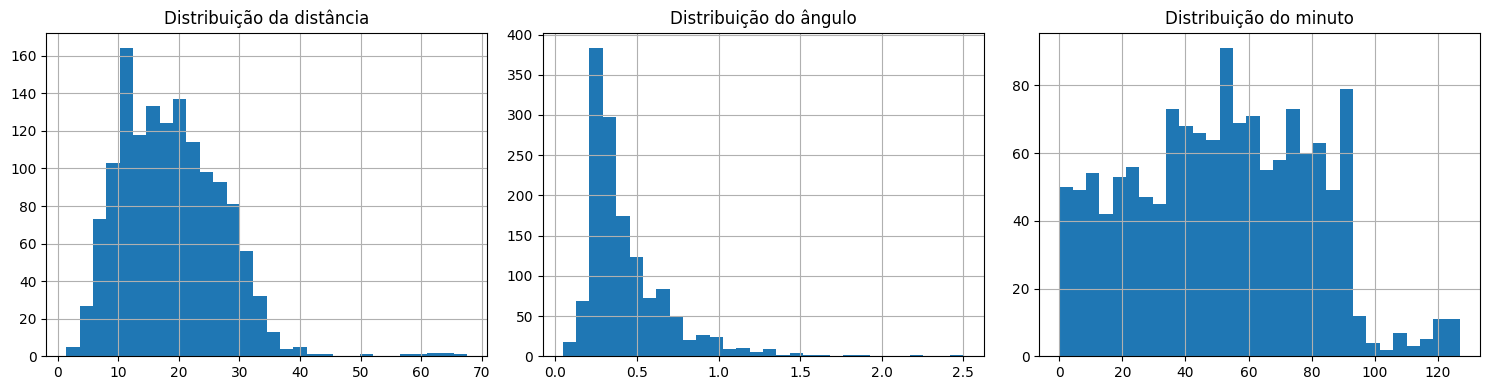

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

df["distance"].hist(bins=30, ax=axes[0])
axes[0].set_title("Distribuição da distância")

df["angle"].hist(bins=30, ax=axes[1])
axes[1].set_title("Distribuição do ângulo")

df["minute"].hist(bins=30, ax=axes[2])
axes[2].set_title("Distribuição do minuto")

plt.tight_layout()
plt.show()


## 4. Prepare features for modeling

We will use `FEATURE_COLUMNS` and apply simple one-hot encoding with `pandas.get_dummies`.


In [9]:
X = pd.get_dummies(df[FEATURE_COLUMNS], drop_first=True)
y = df["is_goal"].values

X.shape, y.shape


((1390, 19), (1390,))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_val.shape


((1112, 19), (278, 19))

## 5. Model comparison and selection

We will compare Logistic Regression and RandomForest using ROC AUC with cross-validation.


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np

models = {
    "logreg": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
    ),
    "random_forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1,
    ),
}



In [12]:
for name, model in models.items():
    scores = cross_val_score(
        model,
        X_train,
        y_train,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1,
    )
    print(name, "ROC AUC:", scores.mean(), "+/-", scores.std())


logreg ROC AUC: 0.7554276411419268 +/- 0.05077008233692461
random_forest ROC AUC: 0.7716144349477683 +/- 0.04959418264449979


## 6. Feature importance (Logistic Regression)

After fitting Logistic Regression, we can inspect the absolute coefficients.


In [13]:
logreg = models["logreg"]
logreg.fit(X_train, y_train)

importance = pd.Series(
    np.abs(logreg.coef_[0]),
    index=X_train.columns,
).sort_values(ascending=False)

importance.head(20)


shot_type_Penalty              1.477937
play_pattern_Other             1.195050
body_part_Left Foot            1.126487
body_part_Right Foot           1.100840
angle                          0.861181
play_pattern_From Kick Off     0.852076
play_pattern_From Counter      0.739689
play_pattern_From Free Kick    0.563225
body_part_Other                0.515124
first_time                     0.459444
shot_type_Open Play            0.449891
play_pattern_Regular Play      0.434274
play_pattern_From Throw In     0.388476
play_pattern_From Keeper       0.197260
distance                       0.105306
play_pattern_From Goal Kick    0.088888
under_pressure                 0.006585
minute                         0.001712
second                         0.000318
dtype: float64

## 7. Simple hyperparameter tuning (RandomForest)

We will run a small `GridSearchCV` for RandomForest.


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
}

rf = RandomForestClassifier(
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
)

grid = GridSearchCV(
    rf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best ROC AUC:", grid.best_score_)


Best params: {'max_depth': 5, 'n_estimators': 200}
Best ROC AUC: 0.7745459794849113


## 8. Conclusion and connection to `train.py`

- This notebook is for **exploration**, feature selection and model comparison.
- The `train.py` script in the project trains the final model (with preprocessing + calibration) on all shots and saves the pipeline in `models/`.
- The web service (`predict.py`) loads this pipeline and exposes the `/predict` endpoint to receive shots and return `prob_goal`.
